# Pneumonia-Diagnosis-using-XRays

## Import Packages

In [53]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
import skimage
from skimage.transform import resize

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

## Problem Understanding

The risk of pneumonia is immense for many, especially in developing nations where billions face energy poverty and rely on polluting forms of energy.  In such regions, the problem can be further aggravated due to the dearth of medical resources and personnel. For these populations, accurate and fast diagnosis means everything. It can guarantee timely access to treatment and save much needed time and money for those already experiencing poverty.
My work includes self laid neural network which was repeatedly tuned for one of the best hyperparameters and used variety of utility function of keras like callbacks for learning rate reduction and checkpointing. Data augmentation was used for a better modelling. Other metrics like precision , recall and f1 score using confusion matrix were taken off special care. 

## Data Understanding



In [48]:
# Importing the datasets
input_path = '/Users/nd/desktop/untitled folder/chest_xray/chest_xray/'
train_dir = "/Users/nd/desktop/untitled folder/chest_xray/chest_xray/train/"
val_dir = "/Users/nd/desktop/untitled folder/chest_xray/chest_xray/val/"
test_dir = "/Users/nd/desktop/untitled folder/chest_xray/chest_xray/test/"

In [80]:
# #
# fig, ax = plt.subplots(2, 3, figsize=(15, 7))
# ax = ax.ravel()
# plt.tight_layout()

# for i, _set in enumerate(['train', 'val', 'test']):
#     set_path = input_path+_set
#     ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
#     ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
#     ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
#     ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [50]:
# Importing the training classes
Pneu_images = os.listdir(train_dir + "PNEUMONIA")
No_images = os.listdir(train_dir + "NORMAL")

No Pneumonia (Left) Vs  Pneumonia (Right)
-----------------------------------------------------------------------------------------------------------------------------------


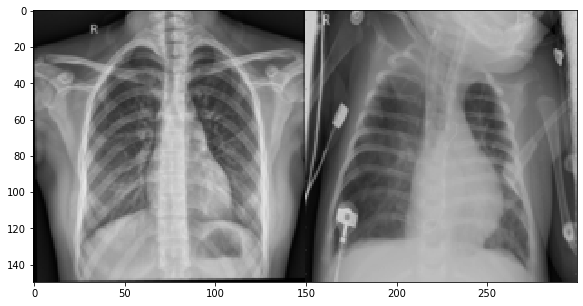

No Pneumonia (Left) Vs  Pneumonia (Right)
-----------------------------------------------------------------------------------------------------------------------------------


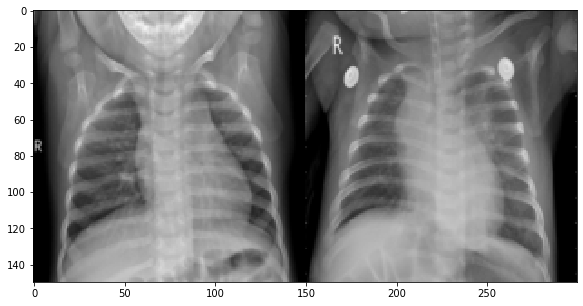

No Pneumonia (Left) Vs  Pneumonia (Right)
-----------------------------------------------------------------------------------------------------------------------------------


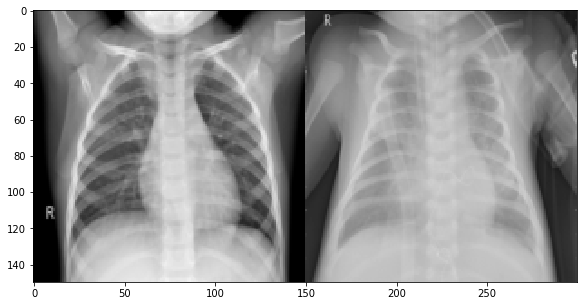

No Pneumonia (Left) Vs  Pneumonia (Right)
-----------------------------------------------------------------------------------------------------------------------------------


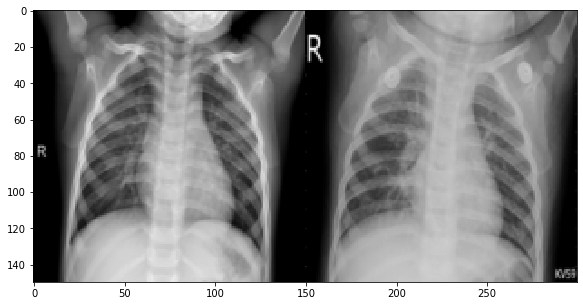

No Pneumonia (Left) Vs  Pneumonia (Right)
-----------------------------------------------------------------------------------------------------------------------------------


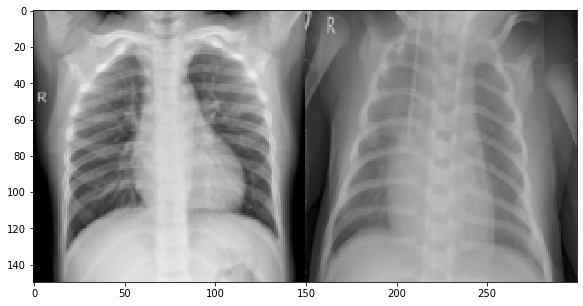

In [54]:
# Function used to plot some training data (Normal and Pneumonia)             
def plotter(i):
    imagep1 = cv2.imread(train_dir+"PNEUMONIA/"+Pneu_images[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir+"NORMAL/"+No_images[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("No Pneumonia (Left) Vs  Pneumonia (Right)")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [70]:
# Length of each class
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))


Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


##  Preprocessing the Data

In [81]:
# Function for Data generation objects
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

## Modeling

In [72]:
# Defining some constants
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [83]:
#Build the first model
inputs = Input(shape=(img_dims, img_dims, 3))

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_35 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
separable_conv2d_36 (Separab (None, 37, 37, 64)        2400

In [ ]:
# Fit_generator function
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


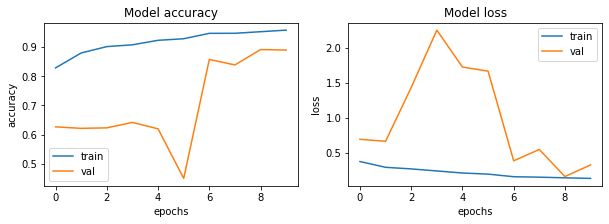

In [59]:
# PLotting the model's output
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Data Augmentation

In [40]:
# Hyperparameter optimization
# Image preprocessing
train_data = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

val_data = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)



# Image reader of different datasets
train_g = train_data.flow_from_directory(train_dir, 
                                        target_size=(150, 150),
                                        batch_size=36,
                                        class_mode='binary')

val_g= val_data.flow_from_directory(val_dir, 
                                    target_size=(150, 150), 
                                    batch_size=36, 
                                    class_mode='binary')

history = model.fit_generator(train_g, steps_per_epoch=train_g.samples // batch_size, 
           epochs=epochs, validation_data=val_g, 
           validation_steps=val_g.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 371s 2s/step - loss: 0.1550 - accuracy: 0.9412 - val_loss: 1.0618 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 346s 2s/step - loss: 0.1584 - accuracy: 0.9407 - val_loss: 1.0869 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 335s 2s/step - loss: 0.1588 - accuracy: 0.9398 - val_loss: 1.2106 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 327s 2s/step - loss: 0.1590 - accuracy: 0.9405 - val_loss: 1.3320 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 364s 2s/step - loss: 0.1475 - accuracy: 0.9411 - val_loss: 1.3679 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 371s 2s/step - loss: 0.1562 - accuracy: 0.9383 - val_loss: 1.0872 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 322s 2

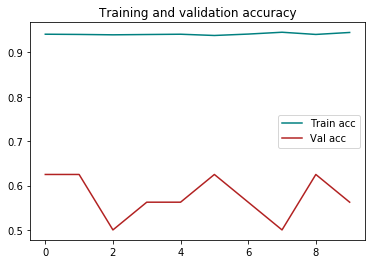

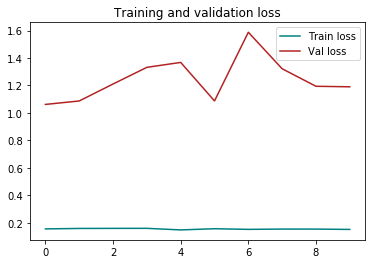

In [45]:
# Plotting of augmented model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'teal', label='Train acc')
plt.plot(epochs, val_acc, 'firebrick', label='Val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'teal', label='Train loss')
plt.plot(epochs, val_loss, 'firebrick', label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [95]:
sec = Sequential()

sec.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 3)))
sec.add(MaxPool2D(pool_size=(2,2),strides=2))

sec.add(Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
sec.add(MaxPool2D(pool_size=(2,2),strides=2))

sec.add(Flatten())
sec.add(Dense(32, activation='relu'))
sec.add(Dense(1, activation='sigmoid'))

sec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
sec.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 128)     3584      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2803744   
_________________________________________________________________
dense_28 (Dense)             (None, 1)                

In [98]:
hist_s = sec.fit_generator(
           train_gen, steps_per_epoch=50, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Epoch 1/10
50/50 [==============================] - 143s 3s/step - loss: 0.3505 - accuracy: 0.8575 - val_loss: 0.4724 - val_accuracy: 0.7105
Epoch 2/10
50/50 [==============================] - 138s 3s/step - loss: 0.3145 - accuracy: 0.8612 - val_loss: 0.4161 - val_accuracy: 0.7635
Epoch 3/10
50/50 [==============================] - 123s 2s/step - loss: 0.2908 - accuracy: 0.8850 - val_loss: 0.3933 - val_accuracy: 0.8581

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
50/50 [==============================] - 123s 2s/step - loss: 0.2442 - accuracy: 0.9019 - val_loss: 0.3750 - val_accuracy: 0.8395
Epoch 5/10
50/50 [==============================] - 122s 2s/step - loss: 0.2472 - accuracy: 0.9044 - val_loss: 0.4016 - val_accuracy: 0.7956

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
50/50 [==============================] - 122s 2s/step - loss: 0.2305 - accuracy: 0.9013 - val_loss: 0.3228 - val_accuracy:

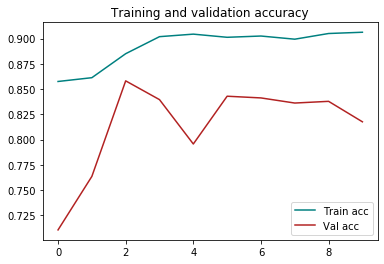

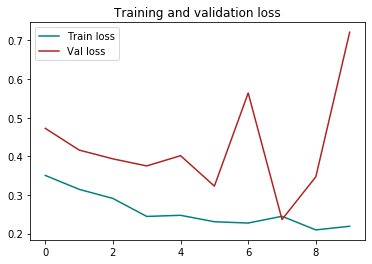

In [105]:
acc = hist_s.history['accuracy']
val_acc = hist_s.history['val_accuracy']
loss = hist_s.history['loss']
val_loss = hist_s.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'teal', label='Train acc')
plt.plot(epochs, val_acc, 'firebrick', label='Val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'teal', label='Train loss')
plt.plot(epochs, val_loss, 'firebrick', label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [106]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')
test_loss, test_acc = sec.evaluate_generator(test_generator, steps=50)
print('Test acc:', test_acc)

Found 624 images belonging to 2 classes.
Test acc: 0.8221544623374939


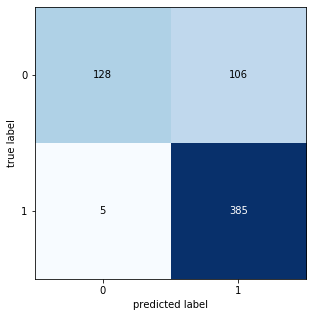

In [107]:
# Confusion matrix 
from sklearn.metrics import accuracy_score, confusion_matrix

preds = sec.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [108]:
# printed all Scores
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


TEST METRICS ----------------------
Accuracy: 82.21153846153845%
Precision: 78.41140529531569%
Recall: 98.71794871794873%
F1-score: 87.40068104426788

TRAIN METRIC ----------------------
Train acc: 95.65


In [109]:
test_images, test_labels = next(test_generator)

In [110]:
# y_true
test_labels

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0.], dtype=float32)

In [120]:
test_datagen_t = ImageDataGenerator(rescale=1./255)

test_generator_t = test_datagen_t.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=100, 
                                                  class_mode='binary')
test_loss, test_acc = sec.evaluate_generator(test_generator_t, steps=50)
print('Test acc:', test_acc)

Found 624 images belonging to 2 classes.
Test acc: 0.8184870481491089


In [123]:
test_images, test_labels = next(test_generator_t)

In [124]:
test_labels

array([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [130]:
#####. test
y_pred = sec.predict_proba(test_images)

fpr_v,tpr_v,thr_v = roc_curve(test_labels,y_pred)


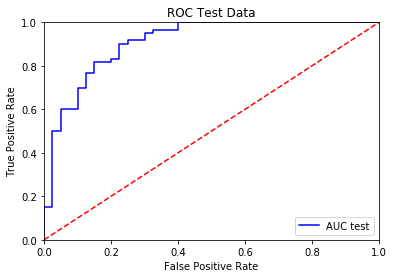

In [135]:
from sklearn.metrics import roc_curve
# fpr_t,tpr_t,thr_t = roc_curve(y_train_s,y_pred)
fpr_v,tpr_v,thr_v = roc_curve(test_labels,y_pred)

plt.title('ROC Test Data')
# plt.plot(fpr_t, tpr_t, 'red', label = 'AUC train')
plt.plot(fpr_v, tpr_v, 'b', label = 'AUC test')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()